In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

<div style="background-color: pink; padding: 10px">
# YOUR SURNAME: CAPRILE YOUR NAME: RICCARDO

# Understanding the Viola and Jones face detector

The goal of the lab is to encourage you do dive deeper into some core aspects of the VJ detector implementation and usage. The activity is devided into 2 somewhat independent parts. 



<div style="background-color: pink; padding: 10px">
Read all the parts (text and comments), and add your own comments whenever you find them appropriate (on the implementation choices, on the output you obtain...), but in particular where you are asked


## Part1: Understanding building blocks

### 1.1: Integral images

Even if you will find an implementation of integral images already available on OpenCV, it will be instructive to do your own. Follow the instructions below.

<i>NOTICE (This was not clearly explained in the class but it is important to obtain an efficient implementation):</i>
<br>
    In each position of the image <tt>(y,x)</tt> except from the first row (y=0) and first column (x=0) the value of the value of the integral image is computed by updating previously computed values see as follows  
<img src="sketch.png" width=600>


In [3]:
def integral_image(image):
    height, width = image.shape
    ii = np.zeros(image.shape)
    s = np.zeros(image.shape) # aux structure to precompute the sum of preceeding elements in the current row
    for y in range(height): 
        for x in range(width): 
            s[y][x] = s[y-1][x] + image[y][x] if y > 0 else image[y][x]
            ii[y][x] = s[y][x] + ii[y][x-1]
    return ii

<b>Test</b> it on a real image and on a synthetic image.
To <b>evaluate</b> the quality of your result you may compare it with the OpenCV implementation <tt>cv2.integral</tt>

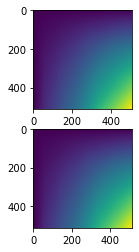

In [7]:
# load a real image
img = cv2.imread('Lena.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.subplot(2,1,1)
plt.imshow(integral_image(gray))

#Comparison wih OpenCV cv2.integral
plt.subplot(2,1,2)
plt.imshow(cv2.integral(gray))
plt.show()


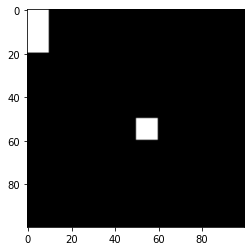

In [8]:
# BUILD a simple synthetic B/W image, for instance white rectangles over a black background (but you can make different ones)

# here's my example

I = np.zeros((100,100))

I[0:20,0:10]=255
I[50:60,50:60]=255

# before you run the integral image function ask yourself how you would expect the integral image to be in this case. 
# in the next cell you will check the actual output and be sure it makes sense to you

plt.imshow(I,cmap='gray')      
    

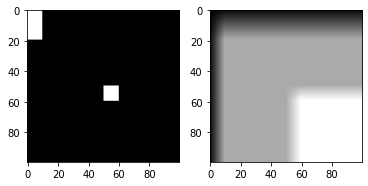

In [13]:
#now you can visualize the integral image 
plt.subplot(1,2,1) 
plt.imshow(I,cmap='gray')    
plt.subplot(1,2,2)
ii=integral_image(I)
plt.imshow(ii,cmap='gray')  



<div style="background-color: pink; padding: 10px">
On this first part there are no comments to add, but I suggest you do your best to check that  your implementation is correct and that at this point you really understand what an integral image is (you may try and change the synthetic image and see if the ii you produce makes sense to you)

### 1.2: The response of a rectangle feature of your choice

We now reason on the quality and quantity of rectangle features over an image. You may use the synthetic image for this part.

You first need to implement a function <tt>compute_rectangle</tt> that computes the sum of all the elements within a rectangle, exploiting the integral image (see formula on the slides)

Then 
- Select a Haar feature of your choice, choosing the pattern, the size and the aspect ratio. The only parameter changing would be its position wrt the image
- Apply it to the image and obtain a feature vector. Does the size and its values make sense to you?

In [14]:
# ii is an integral image, x starting column, y starting row, width and height of the rectangle
# search the formula in the slides
def compute_rectangle(ii, x, y, width, height):
    return ii[y][x]+ii[y+height][x+width]-ii[y][x+width]-ii[y+height][x]


In [18]:
# this is a very naif implementation, you should just use it to get a feeling 
# of the procedure. Try and understand what it does
# if you've time you can do better than this
# here I chose a feature of a 20x20 square feature with a vertical WHITE,BLACK structure (fixed scale and aspect ratio)

def build_my_features(ii):
    height, width = ii.shape
    myw=10
    myh=20
    m=5 # feature's min size
    features = []
    #for w in range(m, width-m):  # you should uncomment this if you want to try out different sizes and aspect ratio
        #for h in range(m, height-m):
    for w in range(myw, myw+1): #these are dummy for just for consistency with the previous commented ones!
        for h in range(myh, myh+1):
            i = 0
            while i + 2*w < width:
                j = 0
                while j + h < height:
                    pos = compute_rectangle(ii,i, j, w, h)  
                    neg = compute_rectangle(ii,i+w, j, w, h)  
                    features.append(([pos],[neg] ))              
                    j += 1
                i += 1
    return features

# features is a list of [[pos] [neg]] elements, one per each appropriate position in the image
# pos contains the sum of pixels values corresponding to the feature white area (of a given position in the image)
# neg contains the sum of pixels values corresponding to the feature black area 

<div style="background-color: pink; padding: 10px">  <b>OPTIONAL</b>: implement another function that computes 20x20 square features with a <b> horizontal </b> WHITE,BLACK structure

In [19]:
# in this function you will explore the list of features previosuly computed and compute the feature value 
#  (sum white elements - sum black elements)
def apply_features(features):
    X = np.zeros((len(features)))
    i=0
    for positive_region, negative_region in features:
        X[i] = positive_region[0]-negative_region[0]
        i += 1
    return X 

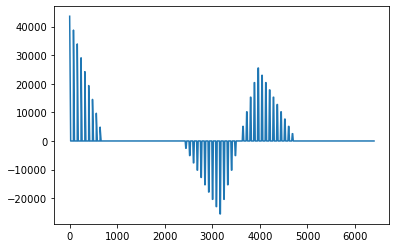

In [20]:
# run the functions on the synthetic image and
# for a better understanding you should change the synthetic image you're using
F=build_my_features(ii)
A=apply_features(F)
plt.plot(A)

<div style="background-color: pink; padding: 10px">
Describe the output you obtain, does it make sense? to you understand what it means? (it may be useful to change the input synthetic feature to see how the feature vector changes

**Comment**

The sythtetic image created before has a white rectangle on top left and in the middle.

The values of the array correspond to : the sum of the white elements - the sum of the black elements.

 For this reason it is ok that when the feature overlaps black background , the value in the arry is 0.
 
 ** ** 


We have just computed a feature vector of an image for a subset of the possible rectangle features (1 type, 1 aspect ratio, 1 size). Optionally, I suggested you could try with another one, in case you tried, the two vectors should be concatenated. 

In the real case we would concatenate all the possible variants of feature type, aspect ratio, size. Then we would build a feature matrix with one row per image. Similar image should have the same structure.
 


## Part 2: Give it a try!

### 2.2 Face detection 

By now you should have a feeling of the type of feature vectors we may compute. Feature selection and training would be too long for a 2 hours lab, thus we play with the pre-implemented cascade classifier. You'll need to get familiar with the OpenCV function

<tt> Python: cv2.CascadeClassifier.detectMultiScale(image, scale_factor=1.1, min_neighbors=3, flags=0, min_size=(0, 0)) → detectedObjects</tt>

Parameters:	
- image – Matrix containing a graylevel image where objects are detected.
- objects – Vector of rectangles where each rectangle contains the detected object.
- scaleFactor – Parameter specifying how much the image size is reduced at each image scale.
- minNeighbors – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
- flags – Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. It is not used for a new cascade.
- minSize – Minimum possible object size. Objects smaller than that are ignored.
- maxSize – Maximum possible object size. Objects larger than that are ignored.

The detected objects will be returned as a list of rectangles

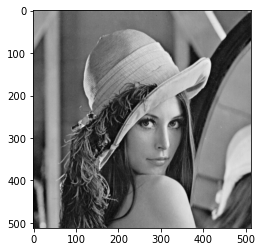

In [21]:
# We first load a classifier from an XML file
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# We now load an image and turn it to gray levels (don't forget this!)
img = cv2.imread('Lena.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray' )

In [22]:
# notice: the following call is correct, but you must improve the results by adding optional parameters 
faces = face_cascade.detectMultiScale(gray)

# let's have a look at the output
print(faces)

[[218 202 173 173]]


In [23]:
def draw_rects(img, rects, color):
    for x1, y1, x2, y2 in rects:
        cv2.rectangle(img, (x1, y1), (x1+x2, y1+y2), color, 2)

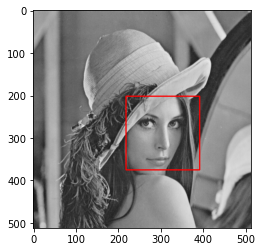

In [29]:
draw_rects(img,faces,color = (255,0,0))
plt.imshow(img)

### Your tests

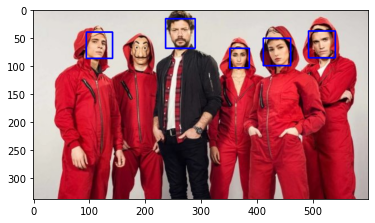

In [34]:
# detect and visualize faces in the following two images, complete all the required steps

cdp = cv2.imread('cdp2.jpg')
rgb = cv2.cvtColor(cdp,cv2.COLOR_BGR2RGB)
faces = face_cascade.detectMultiScale(rgb)
draw_rects(rgb,faces,color=(0,0,255))
plt.imshow(rgb)
plt.show()
# FILL HERE

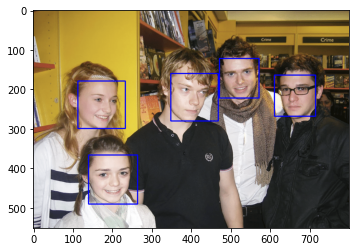

In [37]:
got = cv2.imread('got.png')
rgb = cv2.cvtColor(got,cv2.COLOR_BGR2RGB)
faces = face_cascade.detectMultiScale(rgb)
draw_rects(rgb,faces,color=(0,0,255))
plt.imshow(rgb)
plt.show()

# FILL HERE

In [53]:
def rotation(image, angle):
    width,height=image.shape[:2]   
    dst = np.zeros((width, height, 3), dtype=np.uint8)

    for u in range(width):
        for v in range(height): 
            x = (u * np.cos(angle)) + (v * np.sin(angle))
            y = (-u * np.sin(angle)) + (v * np.cos(angle)) 
            intx, inty = int(x), int(y)
           
            if 0 < x < width and 0 < y < height:
                dst[u, v] = image[intx, inty]  
    return dst

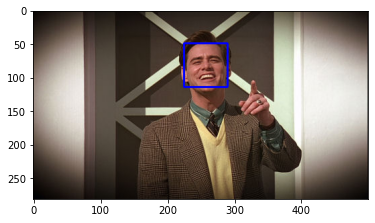

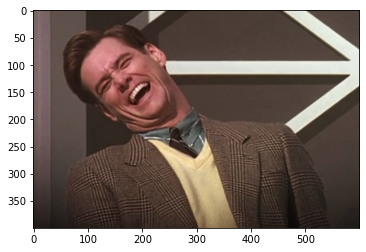

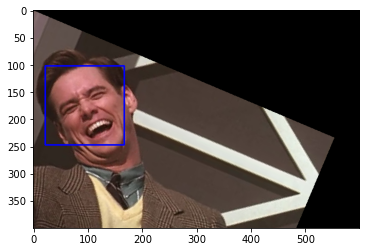

In [67]:
# the model we are using is not robust to inplane rotations, you should check this limitation by comparing 
# the outputs obtained by the following two images 
tr = cv2.imread('truman1.jpg')

# FILL HERE
rgb = cv2.cvtColor(tr,cv2.COLOR_BGR2RGB)
faces = face_cascade.detectMultiScale(rgb)
draw_rects(rgb,faces,color=(0,0,255))
plt.imshow(rgb)
plt.show()


# FILL HERE
tr2 = cv2.imread('truman2.jpg')

rgb = cv2.cvtColor(tr2,cv2.COLOR_BGR2RGB)
faces = face_cascade.detectMultiScale(rgb)
draw_rects(rgb,faces,color=(0,0,255))
plt.imshow(rgb)
plt.show()



# If you apply an appropriate rotation to the second image, results should improve, why?


# FILL HERE
rotated_img = rotation(rgb,-0.4)
faces = face_cascade.detectMultiScale(rotated_img)
draw_rects(rotated_img,faces,color=(0,0,255))
plt.imshow(rotated_img)
plt.show()


### Your comments


The previous tests, involved different types of images and produced different results. Try you reach some conclusion on the limits of the algorithm and, if you want, make an attempt in explaining how they could be mitigated.

It may be interesting to try out other images of your choice (e.g. lateral faces)
   
 

   **Comment** 
    
   In the first image called cdp2.jpg the algorithm was able to detect all the faces except the one person who is wearing a mask. 
    
   In got.png image all the faces are detected correctly.
    
   In the last image truman2.jpg the algorithm has problem for detecting truman's face , it detected the face only after a rotation with a certain angle.
   ****
    

### 2.3 (Optional)  Nested classifiers

The same procedure may be used to train other objects / object parts detectors. Here we will consider an <i> eye detector </i> and will call it in a nested modality (that is inside a region where a face was detected)

In [ ]:
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = cv2.imread('Lena.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray' )

faces = # FILL HERE (DETECT FACES as we did before)
for (x,y,w,h) in faces:
    draw_rects(img,faces,(0,255,0))
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex +ew,ey+eh),(0,0,255),2) #we are exploiting aliases between matrices...

plt.imshow(img)


### 2.4 (Optional) put a face / eye detector in the webcam loop

The following function may be used to run the face (or face+eye) detector on a live video stream acquired through your cam. Try out different acquisition conditions, try and understand the potential and the limits of this powerfull but simple detector

In [ ]:
def show_webcam(width=1000, height=800):
    cam = cv2.VideoCapture(0)
    i=0
    while i<100: # we will acquire 100 frames you may change this if you like
        ret_val, img = cam.read()
             
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # you can first test it like this (to see if your webcam works)
        # then add face detection or face+eye detection and rectangle drawings
        cv2.imshow('my webcam', img)
        cv2.namedWindow('my webcam',cv2.WINDOW_NORMAL)
        cv2.resizeWindow('my webcam', width, height)
        i+=1
    cv2.destroyAllWindows()

In [ ]:
show_webcam()

In [ ]:
# Add some outputs from your camera here if you like (screenshots would do)